# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Jan 27 12:02:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.24.0 requires datasets>=3.0.0, but you have datasets 2.21.0 which is incompatible.
unsloth-zoo 2026.1.4 requires datasets!=4.0.*,!=4.1.0,<4.4.0,>=3.4.1, but you have datasets 2.21.0 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model = Summarizer()

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(250))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 250
})


In [12]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [13]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ]):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [14]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [15]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [16]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [17]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [18]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



Doc: Jairo Medina, 62, a professional carer from Chelsea, was found early on Friday morning by a person w
Prediction: Jairo Medina, 62, a professional carer from Chelsea, was found early on Friday morning by a person walking by who then called the police. The scene was near the mosaic to commemorate The Reformers' Tree in Hyde Park.
Target: A man found dead in London's Hyde Park has been named by police.
[['jairo', 'medina', '62', 'a', 'professional', 'carer', 'from', 'chelsea', 'was', 'found', 'early', 'on', 'friday', 'morning', 'by', 'a', 'person', 'walking', 'by', 'who', 'then', 'called', 'the', 'police', 'the', 'scene', 'was', 'near', 'the', 'mosaic', 'to', 'commemorate', 'the', 'reformers', 'tree', 'in', 'hyde', 'park']]
[[['a', 'man', 'found', 'dead', 'in', 'london', 's', 'hyde', 'park', 'has', 'been', 'named', 'by', 'police']]]
{'Rouge-1-P': 0.18421052631578946, 'Rouge-1-R': 0.5, 'Rouge-1-F': 0.5, 'Rouge-2-P': 0.02702702702702703, 'Rouge-2-R': 0.07692307692307693, 'Rouge-2-F': 0

In [19]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [20]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2026.1.4
Uninstalling unsloth-2026.1.4:
  Successfully uninstalled unsloth-2026.1.4
Found existing installation: unsloth_zoo 2026.1.4
Uninstalling unsloth_zoo-2026.1.4:
  Successfully uninstalled unsloth_zoo-2026.1.4
  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-b5n8f118/unsloth-zoo_2d093fe13c5a41afaef6adac78763a69
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-b5n8f118/unsloth-zoo_2d093fe13c5a41afaef6adac78763a69
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit bb2375ec6ebe00c65cfffc8f533a14b293646d11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 32.6 MB/s eta 0:00:00
  Created wheel for unsloth_zoo: filename=unsloth_zoo-2026.1.4-py3-none-any.whl size=309363 sha256=03795307bac0c16e0185a3d2

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-c8w71du9/unsloth_4908321421404f6489df21b3765cf77b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-c8w71du9/unsloth_4908321421404f6489df21b3765cf77b
  Resolved https://github.com/unslothai/unsloth.git to commit 4cb7229ac1c346e143524b6f9a6ad544259364d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412535 sha256=77771f829b62240f125a389dc18b11cd14789dd41df786c034fc4b2766020981
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9oex6pb/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [22]:
import gc
try:
  del model3
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

360

In [23]:
model3, tokenizer3 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt3 = generate_prompt(tokenizer3, 3)
print(prompt3)
torch.cuda.empty_cache()
data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 28-year-old and rowing partner Grainger, a 2012 gold medallist, compete in the women's double sculls heats at the European Championships.
Thornley, from Wrexham, is confident of securing a place at Rio.
"With it being Katherine's fifth Olympics there's no-one else you'd want sat behind you," she said.
"She knows how to handle pressure so well.
Media playback

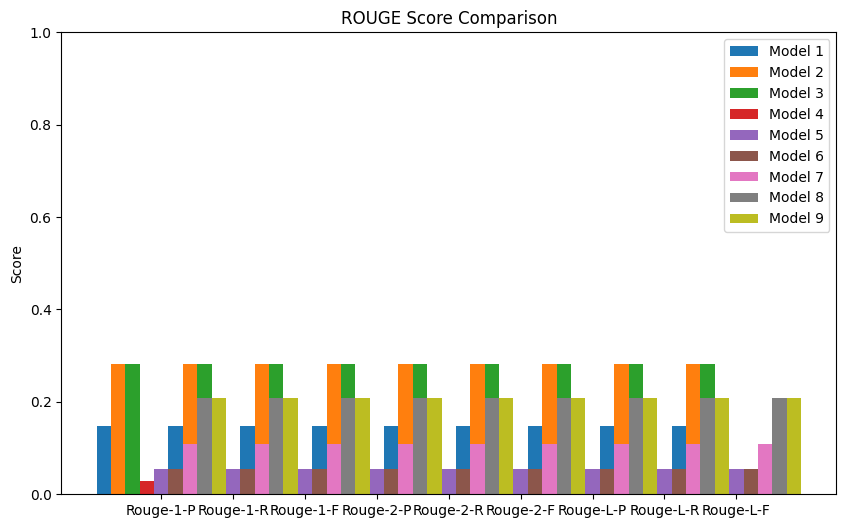

In [24]:
plot_data(data)

In [25]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


Doc: The 28-year-old Scotland international has spent the last two seasons with Wasps, having previously 
Prediction:  The 28-year-old Scottish international has spent the last two seasons with Wasps, having previously had a six-year spell with Glasgow Warriors.
"He's a fantastic player with a lot of potential," said incoming Quins director of rugby John Kingston.

Target: Harlequins have agreed to sign fly-half Ruaridh Jackson from Premiership rivals Wasps ahead of next season.
[['the', '28', 'year', 'old', 'scottish', 'international', 'has', 'spent', 'the', 'last', 'two', 'seasons', 'with', 'wasps', 'having', 'previously', 'had', 'a', 'six', 'year', 'spell', 'with', 'glasgow', 'warriors', 'he', 's', 'a', 'fantastic', 'player', 'with', 'a', 'lot', 'of', 'potential', 'said', 'incoming', 'quins', 'director', 'of', 'rugby', 'john', 'kingston']]
[[['harlequins', 'have', 'agreed', 'to', 'sign', 'fly', 'half', 'ruaridh', 'jackson', 'from', 'premiership', 'rivals', 'wasps', 'ahead', 'of', 'n

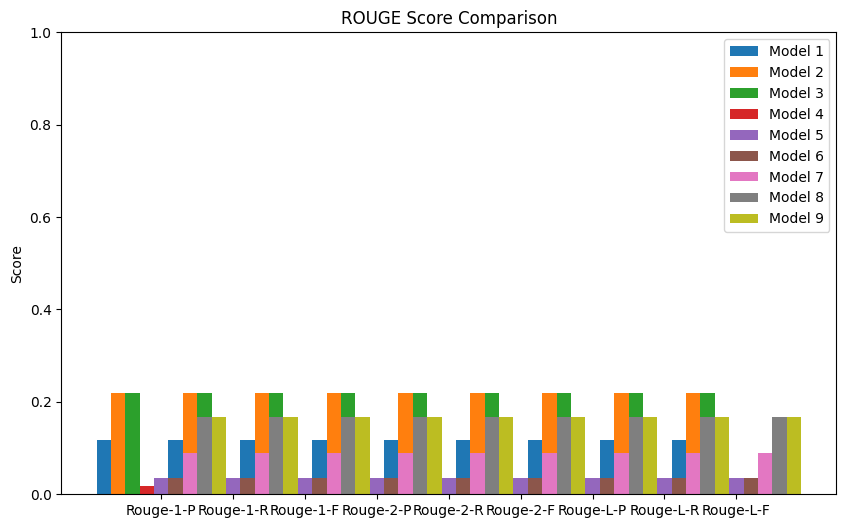

In [26]:
plot_data(data_zero_shot)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path, max_sequence_length=32000, load_in_4bit=False)


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [32]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

Doc: The singer will perform 20 shows under the banner Lionel Richie - All the Hits through April and May
Prediction: The singer Stevie Wonder is to perform at the annual Glastonbury Festival in Somerset, England, as part of his Las Vegas residency. The 80-minute show is due to take place on 13 February. A total of 
Target: Following his barnstorming set at Glastonbury, soul legend Lionel Richie has announced a residency at the Planet Hollywood Resort & Casino in Las Vegas.
[['the', 'singer', 'stevie', 'wonder', 'is', 'to', 'perform', 'at', 'the', 'annual', 'glastonbury', 'festival', 'in', 'somerset', 'england', 'as', 'part', 'of', 'his', 'las', 'vegas', 'residency', 'the', '80', 'minute', 'show', 'is', 'due', 'to', 'take', 'place', 'on', '13', 'february', 'a', 'total', 'of']]
[[['following', 'his', 'barnstorming', 'set', 'at', 'glastonbury', 'soul', 'legend', 'lionel', 'richie', 'has', 'announced', 'a', 'residency', 'at', 'the', 'planet', 'hollywood', 'resort', 'casino', 'in', 'las', 

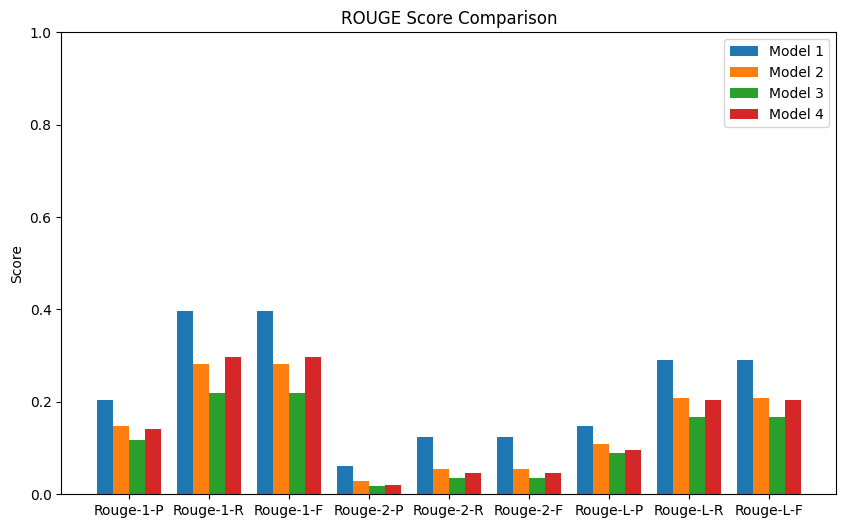

[0.11671199 0.21923196 0.21923196 0.01864448 0.03598092 0.03598092
 0.08836114 0.1667885  0.1667885 ]
[0.20340409 0.39681244 0.39681244 0.06045946 0.12296214 0.12296214
 0.14696576 0.29071592 0.29071592]


In [33]:
plot_data([data_ft, data, data_zero_shot, loss])
print(data_zero_shot)
print(data_ft)